<a href="https://colab.research.google.com/github/Lewis34cs/fb_prophet_blog_notebook/blob/main/blog_prophet_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
#Importing necessary libraries
import pandas as pd
from fbprophet import Prophet

This dataset was retrieved from FRED and then uploaded into my Google Drive.

Link to the original dataset can be found [`here`](https://fred.stlouisfed.org/series/PCU481111481111)


You can also view and download the csv file on my [`Github page`](https://github.com/Lewis34cs/fb_prophet_blog_notebook)

In [14]:
# Loading in dataset
df = pd.read_csv('/content/drive/MyDrive/gdrive/datasets/air_passenger.csv')

The 'DATE' column is in a monthly start format

In [15]:
df.head(13)

,DATE,PCU481111481111
0,1989-12-01,100.0
1,1990-01-01,101.0
2,1990-02-01,104.5
3,1990-03-01,106.9
4,1990-04-01,106.5
5,1990-05-01,107.0
6,1990-06-01,106.6
7,1990-07-01,109.7
8,1990-08-01,109.8
9,1990-09-01,112.5


In [16]:
df.tail()

,DATE,PCU481111481111
370,2020-10-01,250.5
371,2020-11-01,230.5
372,2020-12-01,224.3
373,2021-01-01,223.9
374,2021-02-01,227.7


In order to Prophet to be able to use this dataset, we must change the column names to 'ds' (the datetime column) and 'y' (the value we are trying to predict.

In [17]:
# Setting column names to required column names to be able to work with Prophet
df.columns = ['ds', 'y']

In [18]:
# Setting 'ds' column as a datetime object
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      375 non-null    datetime64[ns]
 1   y       375 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.0 KB


In [20]:
df.head()

,ds,y
0,1989-12-01,100.0
1,1990-01-01,101.0
2,1990-02-01,104.5
3,1990-03-01,106.9
4,1990-04-01,106.5


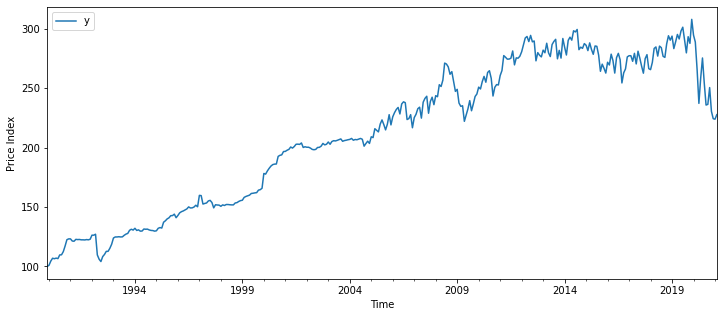

In [131]:
ax = df.plot(x='ds', y='y', figsize=(12,5))
ax.set_xlabel('Time')
ax.set_ylabel('Price Index');

Notice the extreme drop starting from 2020 for the price index for scheduled airline passengers. Because the purpose of this notebook is to show the basics of Prophet to forecast and predict on a time series dataset, we will not be using any values from 2020-01-01 onwards. Instead, we will focus solely on the data within 1989-12-01 to 2019-12-01.

In [21]:
len(df)

375

In [79]:
# Figuring out which index we need to slice out to remove 2020 from the dataframe
sum(df['ds'] > '2019-12-01')

14

In [87]:
# Confirming that the final 14 rows all consist of dates from 2020 onwards
df.iloc[-14:]

,ds,y
361,2020-01-01,294.6
362,2020-02-01,288.8
363,2020-03-01,265.7
364,2020-04-01,237.2
365,2020-05-01,258.4
366,2020-06-01,275.4
367,2020-07-01,254.2
368,2020-08-01,235.8
369,2020-09-01,236.4
370,2020-10-01,250.5


In [114]:
# separating 2020 from the dataframe for the sake of simplicity for this blog
air_df = df.iloc[:-14]

# how many months we want the prophet model to predict
nobs = 12

In [115]:
# We want to predict 1 year, so we will make the test set contain the last year
train = air_df.iloc[:-nobs]
test = air_df.iloc[-nobs:]

In [116]:
len(train), len(test)

(349, 12)

In [117]:
prophet = Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
future = prophet.make_future_dataframe(periods=nobs, freq='MS', include_history=True)

In [119]:
forecast = prophet.predict(future)

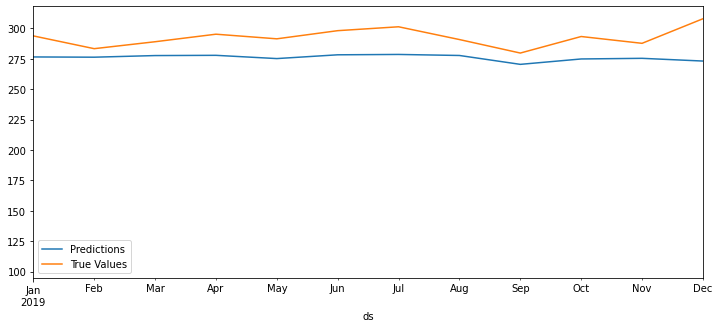

In [120]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,5))
test.plot(x='ds', y='y', label='True Values', ax=ax, xlim=['2019-01-01', '2019-12-01'])

In [121]:
from statsmodels.tools.eval_measures import rmse

In [122]:
y_pred = forecast.iloc[-12:]['yhat']
y_pred

349    276.496760
350    276.291874
351    277.628862
352    277.824387
353    275.152291
354    278.256272
355    278.556495
356    277.702368
357    270.398717
358    274.837197
359    275.362461
360    273.121624
Name: yhat, dtype: float64

In [123]:
test['y']

349    293.8
350    283.3
351    289.0
352    295.2
353    291.4
354    298.1
355    301.3
356    290.8
357    279.7
358    293.3
359    287.7
360    307.9
Name: y, dtype: float64

In [125]:
rmse(y_pred, test['y'])

18.063421849017068

In [128]:
air_df['y'].describe()

count    361.000000
mean     210.134072
std       61.036450
min      100.000000
25%      151.800000
50%      207.700000
75%      271.700000
max      307.900000
Name: y, dtype: float64